In [73]:
import json
import numpy as np
from math import log
import pandas as pd
import os

# Load configuration
with open("../../config/config_notebooks_TNBC.json", "r") as config_file:
    config = json.load(config_file)


In [74]:
name = "uni_full_koleo_4096_prototypes"

invasive_path = os.path.join(config['retrained_benchmark_folder2'], 
                                  "invasive_cancer_clustering",
                                   "kmeans")

In [75]:
optimal_clusters = pd.read_csv(os.path.join(invasive_path, "optimal_clusters.csv"), index_col=0)


In [76]:
metadata = pd.read_excel("/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/ST_TNBC_metadata.xlsx")

In [77]:
metadata.index = metadata['ST_TNBC_ID'].apply(lambda x: f"TNBC{x}")  # Adjust column name if needed

In [78]:
metadata["OS_years"]

ST_TNBC_ID
TNBC1      8.284932
TNBC10    11.282192
TNBC11     2.375342
TNBC12     5.156164
TNBC13     6.756164
            ...    
TNBC92    20.186301
TNBC93    15.769863
TNBC94     3.183562
TNBC95     5.065753
TNBC96     7.520548
Name: OS_years, Length: 94, dtype: float64

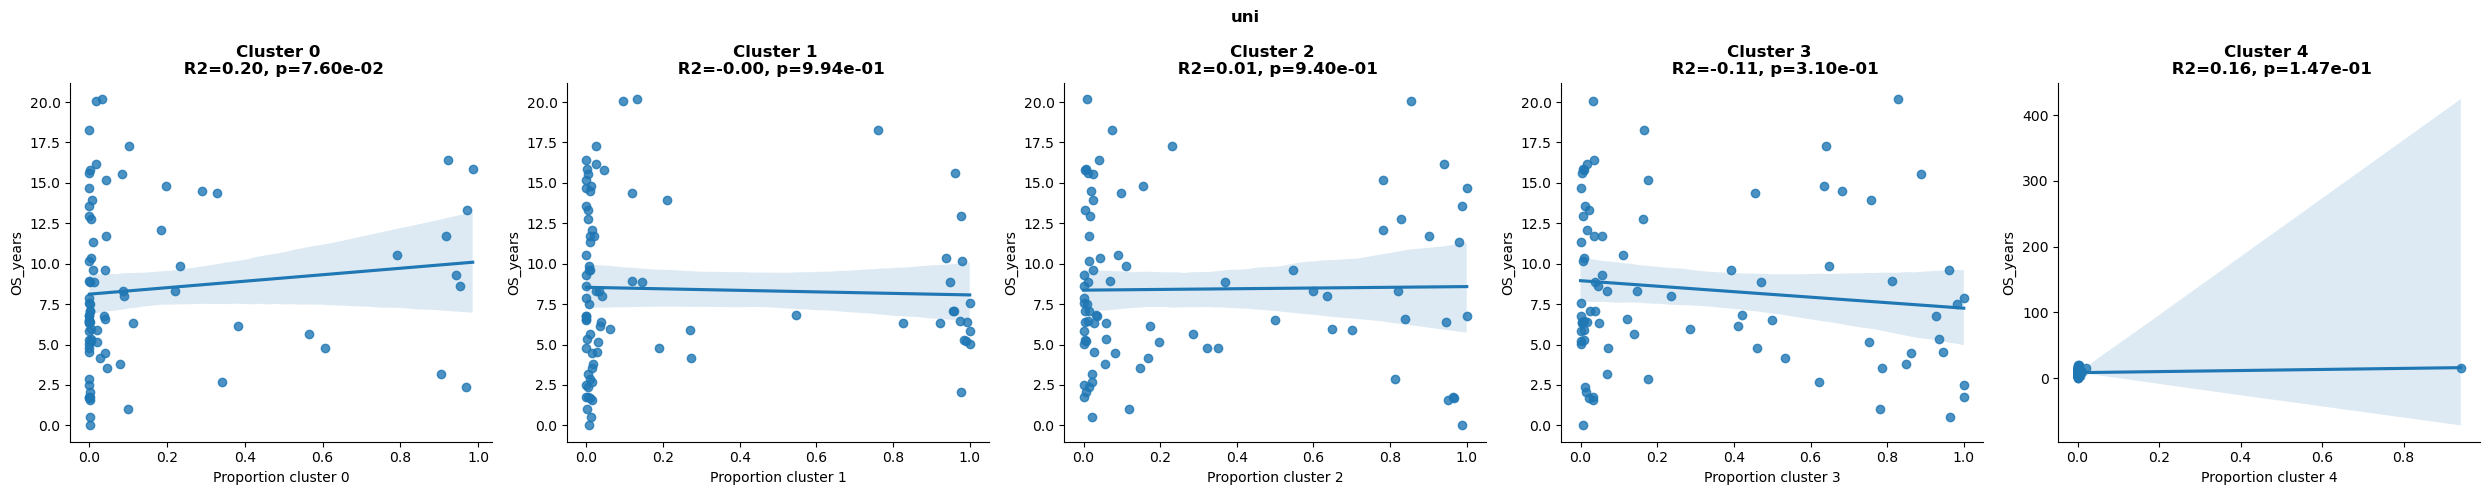

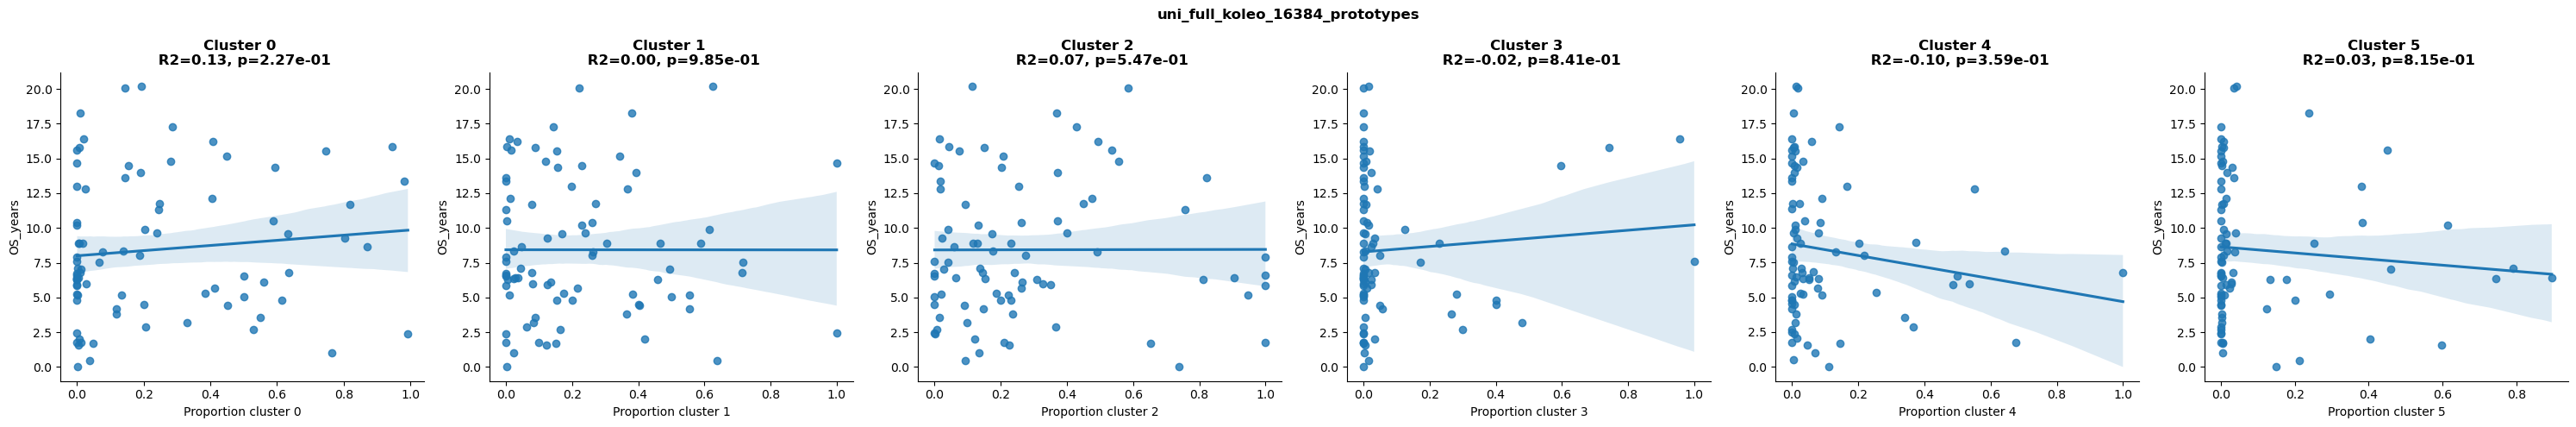

In [79]:
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, pointbiserialr
import matplotlib.pyplot as plt
import glob

for name, n_cluster in zip(["uni", "uni_full_koleo_16384_prototypes"],
                [5,6]):
    filename = glob.glob(os.path.join(invasive_path,
                                        name, 
                                        f"invasive_labels_{optimal_clusters.loc[name, 'n_clusters']}_clusters_umap_min_dist*"))[0]
    df = pd.read_csv(filename, index_col=0)
    df["patient"] = [idx.split("_")[0] for idx in df.index]
    proportions = df.groupby(['patient', 'predicted_label']).size().unstack(fill_value=0)
    proportions = proportions.div(proportions.sum(axis=1), axis=0)
    df_corr = proportions.merge(metadata[['OS_years', 'OS-event']], left_index=True, right_index=True)

    plt.figure(figsize=(5*n_cluster,5))
    for cluster in range(n_cluster):

        plt.subplot(1,n_cluster,cluster+1)
        sns.regplot(x=df_corr[cluster],y=df_corr['OS_years'])
        r, p = spearmanr(df_corr[cluster], df_corr['OS_years'], nan_policy='omit')
        plt.title(f"Cluster {cluster} \n R2={r:.2f}, p={p:.2e}", weight='bold')
        plt.xlabel(f"Proportion cluster {cluster}")
        sns.despine()
    plt.suptitle(name, weight='bold')
    plt.tight_layout()




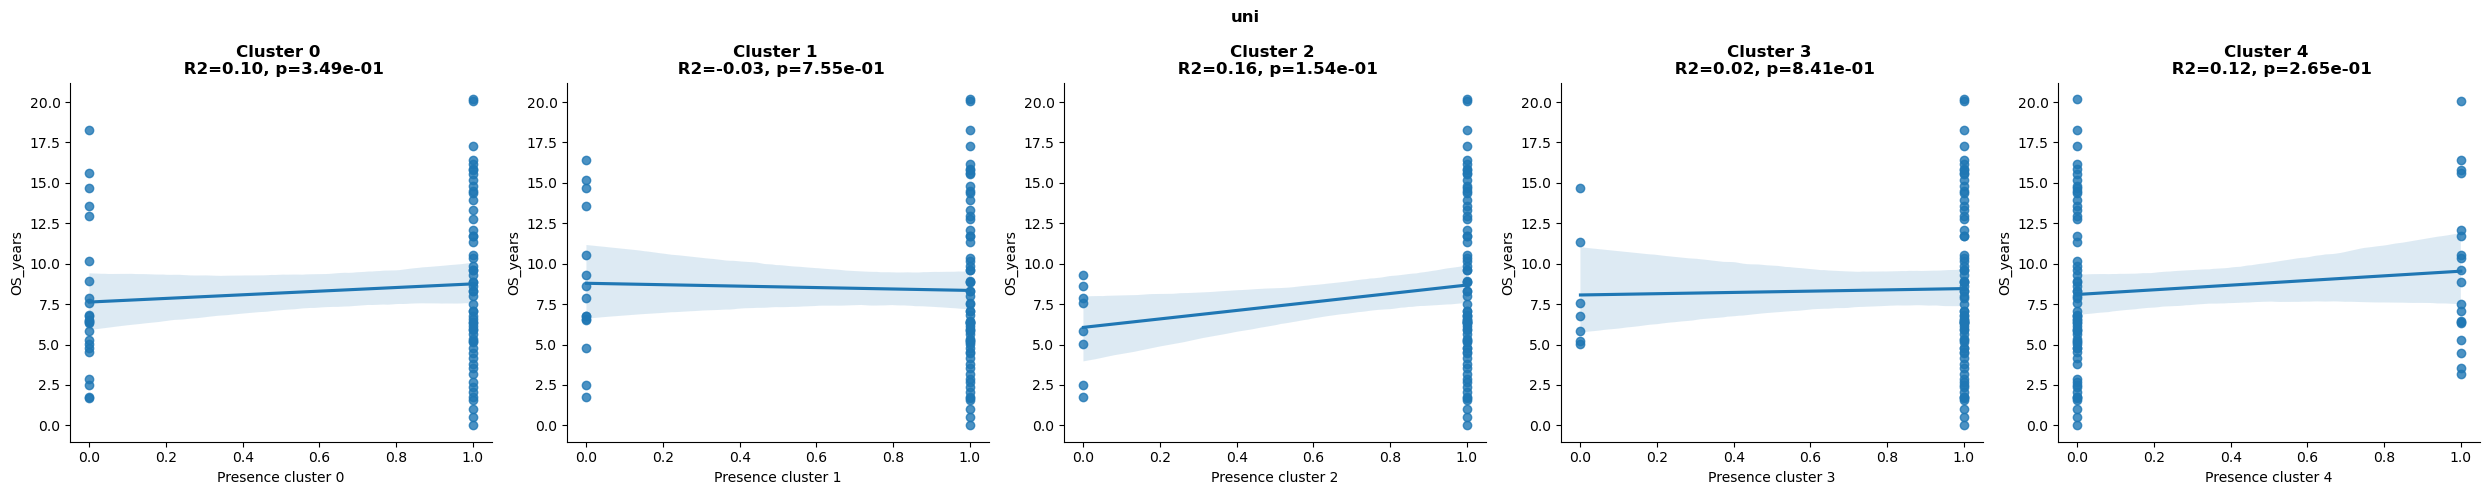

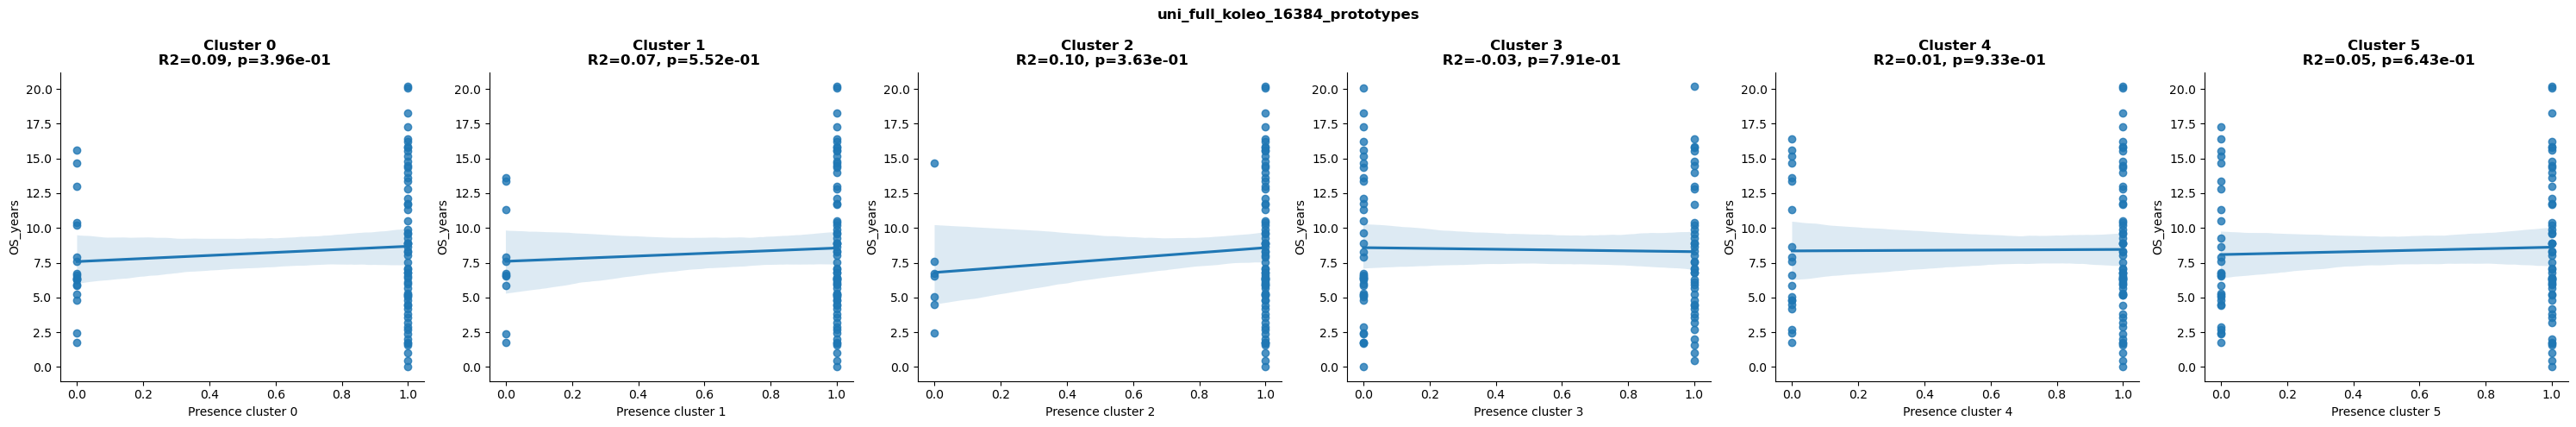

In [80]:
for name, n_cluster in zip(["uni", "uni_full_koleo_16384_prototypes"],
                [5,6]):
    filename = glob.glob(os.path.join(invasive_path,
                                        name, 
                                        f"invasive_labels_{optimal_clusters.loc[name, 'n_clusters']}_clusters_umap_min_dist*"))[0]
    df = pd.read_csv(filename, index_col=0)
    df["patient"] = [idx.split("_")[0] for idx in df.index]
    proportions = df.groupby(['patient', 'predicted_label']).size().unstack(fill_value=0)
    proportions = proportions.div(proportions.sum(axis=1), axis=0)
    proportions = (proportions > 0).astype(int)
    df_corr = proportions.merge(metadata[['OS_years', 'OS-event']], left_index=True, right_index=True)
    df_corr.dropna(inplace=True)

    plt.figure(figsize=(5*n_cluster,5))
    for cluster in range(n_cluster):

        plt.subplot(1,n_cluster,cluster+1)
        sns.regplot(x=df_corr[cluster],y=df_corr['OS_years'])
        r, p = pointbiserialr(df_corr[cluster], df_corr['OS_years'])
        plt.title(f"Cluster {cluster} \n R2={r:.2f}, p={p:.2e}", weight='bold')
        plt.xlabel(f"Presence cluster {cluster}")
        sns.despine()
    plt.suptitle(name, weight='bold')
    plt.tight_layout()


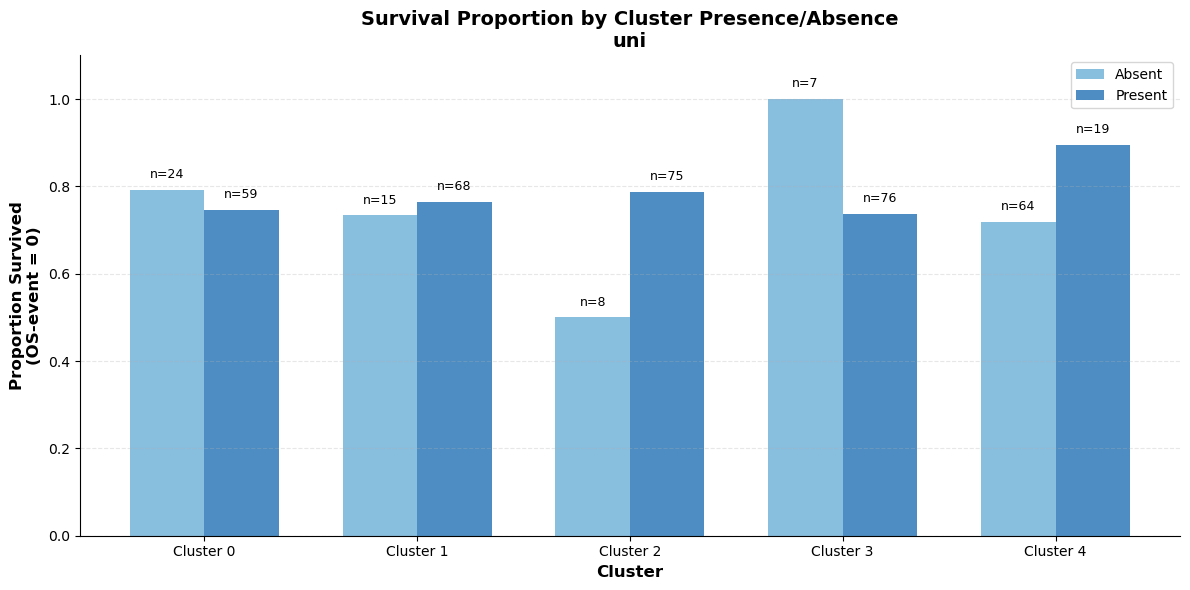

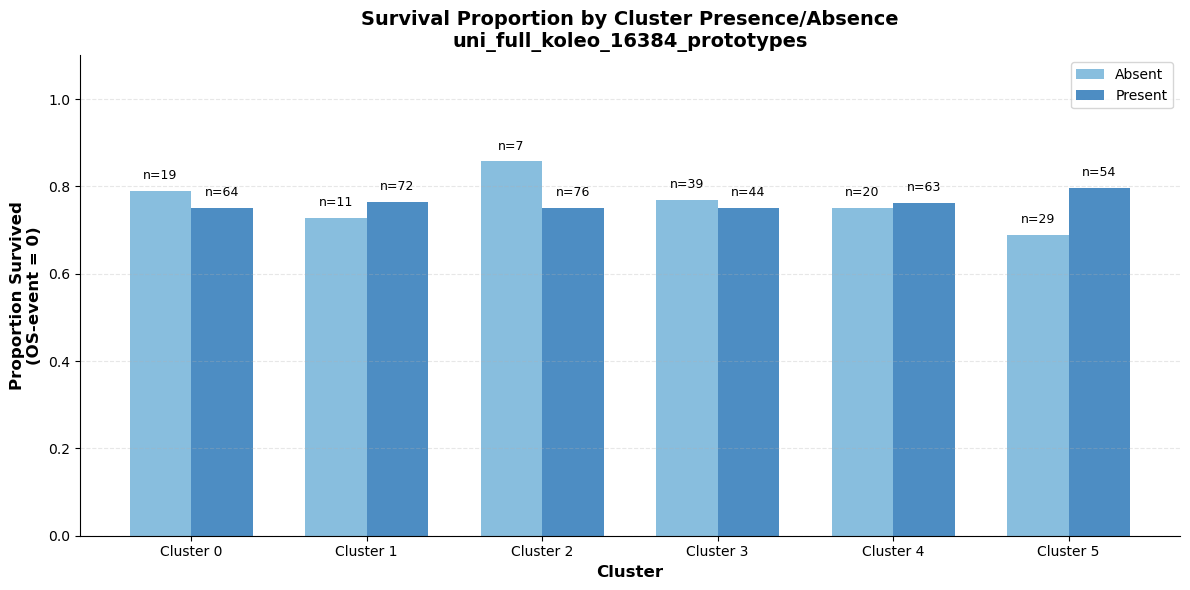

In [81]:
# Barplot: Survival proportion by cluster presence/absence
for name, n_cluster in zip(["uni", "uni_full_koleo_16384_prototypes"],
                [5,6]):
    filename = glob.glob(os.path.join(invasive_path,
                                        name, 
                                        f"invasive_labels_{optimal_clusters.loc[name, 'n_clusters']}_clusters_umap_min_dist*"))[0]
    df = pd.read_csv(filename, index_col=0)
    df["patient"] = [idx.split("_")[0] for idx in df.index]
    proportions = df.groupby(['patient', 'predicted_label']).size().unstack(fill_value=0)
    proportions = proportions.div(proportions.sum(axis=1), axis=0)
    proportions = (proportions > 0).astype(int)
    df_corr = proportions.merge(metadata[['OS_years', 'OS-event']], left_index=True, right_index=True)
    df_corr.dropna(inplace=True)
    
    # Prepare data for plotting
    survival_data = []
    for cluster in range(n_cluster):
        for presence in [0, 1]:
            subset = df_corr[df_corr[cluster] == presence]
            if len(subset) > 0:
                # OS-event: 1 = died, 0 = survived
                # We want proportion who survived (OS-event == 0)
                survival_prop = (subset['OS-event'] == 0).mean()
                survival_data.append({
                    'Cluster': cluster,
                    'Presence': 'Absent' if presence == 0 else 'Present',
                    'Survival_Proportion': survival_prop,
                    'N': len(subset)
                })
    
    survival_df = pd.DataFrame(survival_data)
    
    # Create barplot
    plt.figure(figsize=(12, 6))
    x = np.arange(n_cluster)
    width = 0.35
    
    absent_data = survival_df[survival_df['Presence'] == 'Absent']
    present_data = survival_df[survival_df['Presence'] == 'Present']
    
    bars1 = plt.bar(x - width/2, absent_data['Survival_Proportion'], width, 
                    label='Absent', alpha=0.8, color='#6baed6')
    bars2 = plt.bar(x + width/2, present_data['Survival_Proportion'], width, 
                    label='Present', alpha=0.8, color='#2171b5')
    
    # Add sample sizes as text
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        n_absent = absent_data[absent_data['Cluster'] == i]['N'].values[0] if len(absent_data[absent_data['Cluster'] == i]) > 0 else 0
        n_present = present_data[present_data['Cluster'] == i]['N'].values[0] if len(present_data[present_data['Cluster'] == i]) > 0 else 0
        
        plt.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.02, 
                f'n={n_absent}', ha='center', va='bottom', fontsize=9)
        plt.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.02, 
                f'n={n_present}', ha='center', va='bottom', fontsize=9)
    
    plt.xlabel('Cluster', fontsize=12, weight='bold')
    plt.ylabel('Proportion Survived\n(OS-event = 0)', fontsize=12, weight='bold')
    plt.title(f'Survival Proportion by Cluster Presence/Absence\n{name}', fontsize=14, weight='bold')
    plt.xticks(x, [f'Cluster {i}' for i in range(n_cluster)])
    plt.ylim(0, 1.1)
    plt.legend()
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    sns.despine()
    plt.tight_layout()
    plt.show()

In [82]:
metadata["Grade"].value_counts()

3     82
2      8
3      2
nd     2
Name: Grade, dtype: int64

In [83]:
metadata.columns

Index(['ST_TNBC_ID', 'Age_at_diagnosis', 'Staging_pTNM', 'T_TNM', 'N_TNM',
       'Grade', 'ER.IHC', 'PR.IHC', 'HER2.IHC', 'Ki67_percentage', 'LN.status',
       'Number.of.LN.involvment', 'Germline.mutation', 'CT_ADJ', 'RT_ADJ',
       'Days_between_diagnosis_to_last.follow.up', '1st.Local_Relapse',
       '1st.Local_Relapse_location',
       'Days_between_diagnosis_and_ 1st.Local_Relapse',
       '1st_Local_Relapse.histology', '2nd.Local_Relapse',
       '2nd.Local_Relapse_location', '2nd.Local_Relapse_DATE',
       '2nd.Local_Relapse.histology', 'Distant_Relapse',
       'Days_between_diagnosis_and_ Distant.Relapse',
       'Distant.relapse_location', 'Distant.Relapse.histology',
       'Other_primary_cancer',
       'Days_between_diagnosis_and_ Other_primary_cancer',
       'Other_primary_cancer_location', 'Death',
       'Days_between_diagnosis_and_ Death', 'Death.related.to.breast.cancer',
       'RFS-event', 'RFS_years', 'iBCFS-event', 'iBCFS_years', 'iDFS-event',
       'iDFS_y

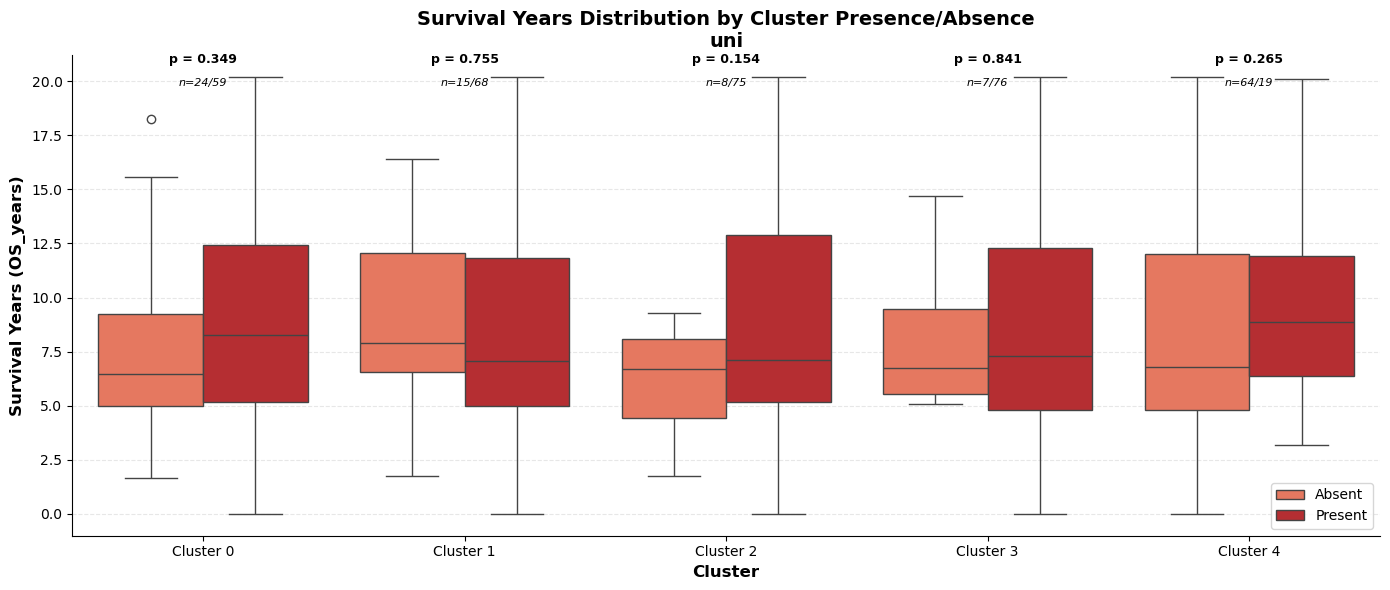

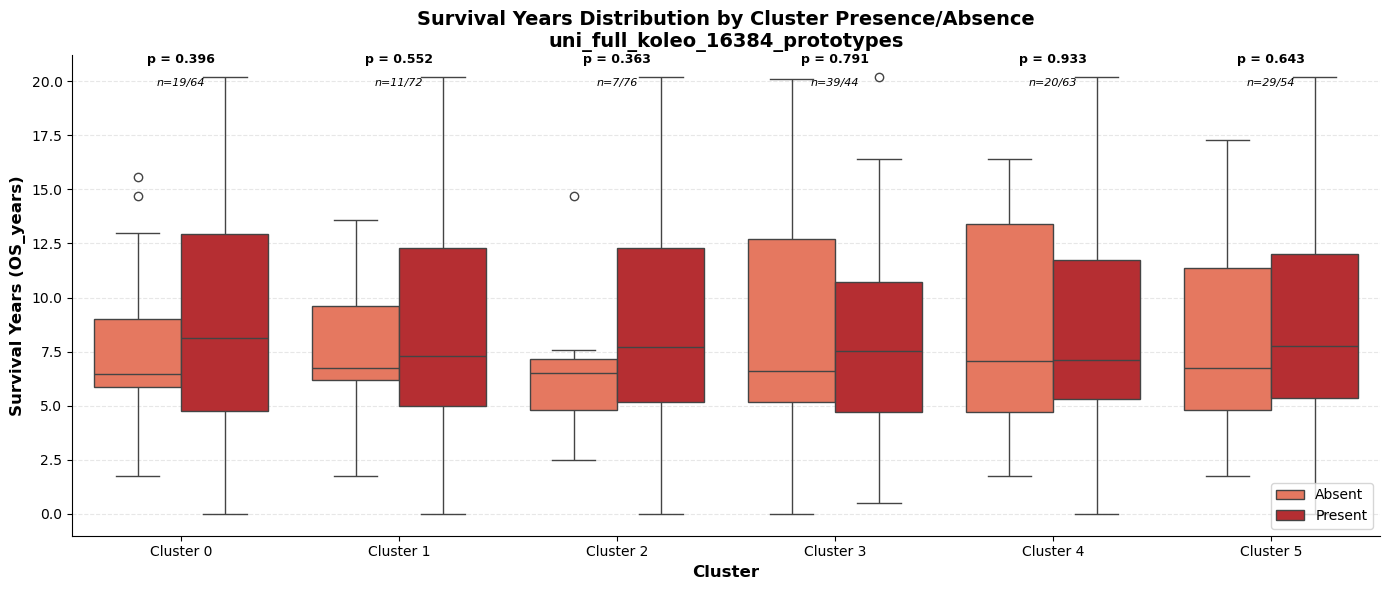

In [84]:
# Boxplot: Survival years distribution by cluster presence/absence
from scipy.stats import mannwhitneyu, ttest_ind

for name, n_cluster in zip(["uni", "uni_full_koleo_16384_prototypes"],
                [5,6]):
    filename = glob.glob(os.path.join(invasive_path,
                                        name, 
                                        f"invasive_labels_{optimal_clusters.loc[name, 'n_clusters']}_clusters_umap_min_dist*"))[0]
    df = pd.read_csv(filename, index_col=0)
    df["patient"] = [idx.split("_")[0] for idx in df.index]
    proportions = df.groupby(['patient', 'predicted_label']).size().unstack(fill_value=0)
    proportions = proportions.div(proportions.sum(axis=1), axis=0)
    proportions = (proportions > 0).astype(int)
    df_corr = proportions.merge(metadata[['OS_years', 'OS-event']], left_index=True, right_index=True)
    df_corr.dropna(inplace=True)
    
    # Prepare data for boxplot
    plot_data = []
    for cluster in range(n_cluster):
        for presence in [0, 1]:
            subset = df_corr[df_corr[cluster] == presence]
            for os_years in subset['OS_years']:
                plot_data.append({
                    'Cluster': f'Cluster {cluster}',
                    'Presence': 'Absent' if presence == 0 else 'Present',
                    'OS_years': os_years
                })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Create boxplot
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Create boxplot with seaborn
    sns.boxplot(data=plot_df, x='Cluster', y='OS_years', hue='Presence', 
                palette={'Absent': '#fb6a4a', 'Present': '#cb181d'}, ax=ax)
    
    # Add p-values and sample sizes
    cluster_labels = [f'Cluster {i}' for i in range(5)]
    x_positions = np.arange(len(cluster_labels))
    
    for i, cluster in enumerate(range(n_cluster)):
        absent_data = df_corr[df_corr[cluster] == 0]['OS_years']
        present_data = df_corr[df_corr[cluster] == 1]['OS_years']
        
        # Compute Mann-Whitney U test (non-parametric alternative to t-test)
        if len(absent_data) > 0 and len(present_data) > 0:
            stat, p_value = ttest_ind(absent_data, present_data, alternative='two-sided')
            
            # Get y position for annotation (top of the plot)
            y_max = plot_df[plot_df['Cluster'] == f'Cluster {cluster}']['OS_years'].max()
            y_pos = y_max + 1.5
            
            # Add p-value
            if p_value < 0.001:
                p_text = f'p < 0.001'
            else:
                p_text = f'p = {p_value:.3f}'
            ax.text(i, y_pos - 1, p_text, ha='center', va='bottom', fontsize=9, weight='bold')
            
            # Add sample sizes
            n_absent = len(absent_data)
            n_present = len(present_data)
            ax.text(i, y_pos - 2, f'n={n_absent}/{n_present}', ha='center', va='bottom', fontsize=8, style='italic')
    
    ax.set_xlabel('Cluster', fontsize=12, weight='bold')
    ax.set_ylabel('Survival Years (OS_years)', fontsize=12, weight='bold')
    ax.set_title(f'Survival Years Distribution by Cluster Presence/Absence\n{name}', fontsize=14, weight='bold')
    ax.legend(title='Presence', loc='upper right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    sns.despine()
    plt.tight_layout()
    plt.legend(loc="lower right")
    plt.show()

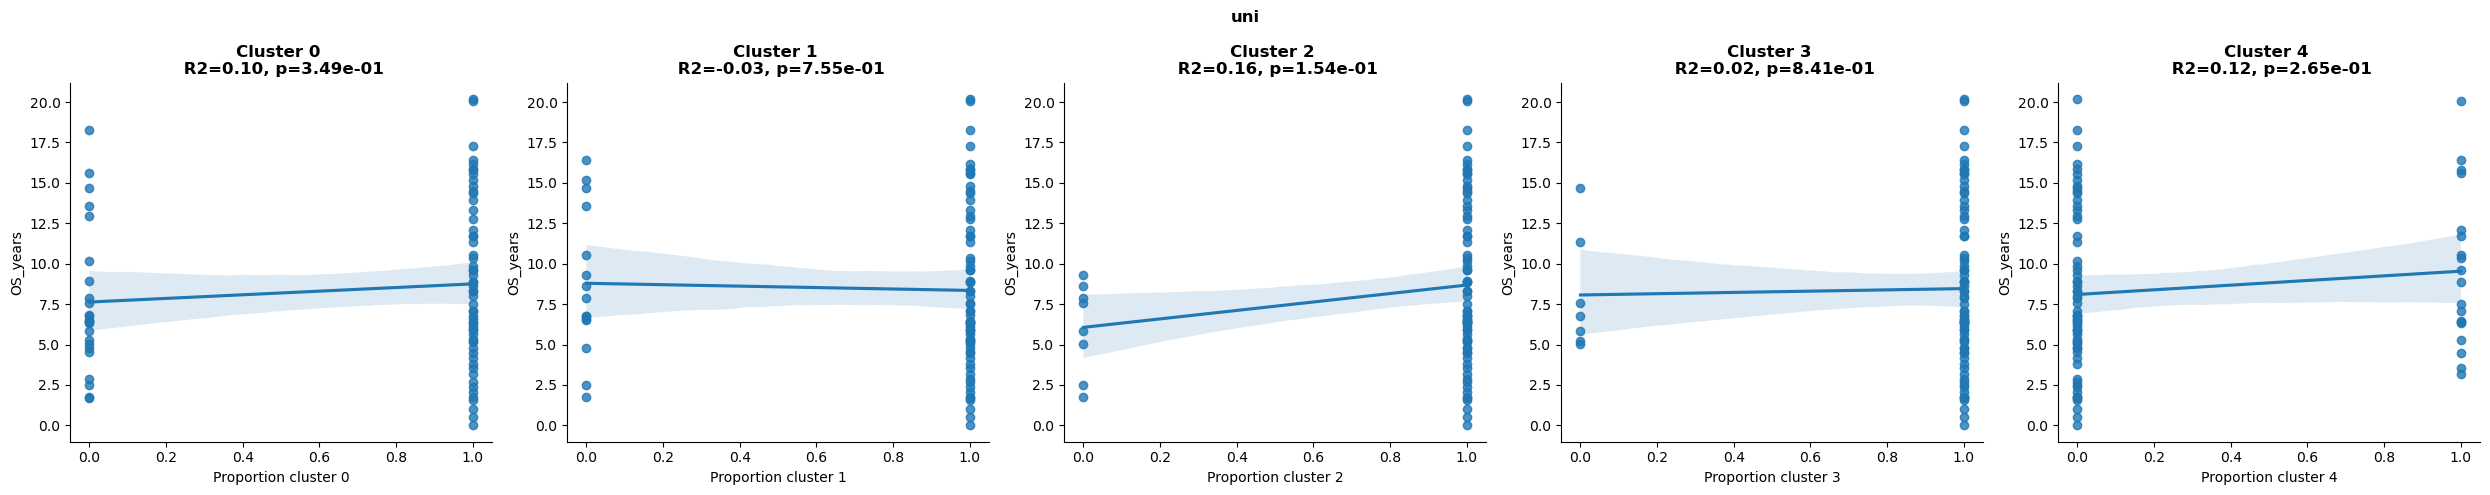

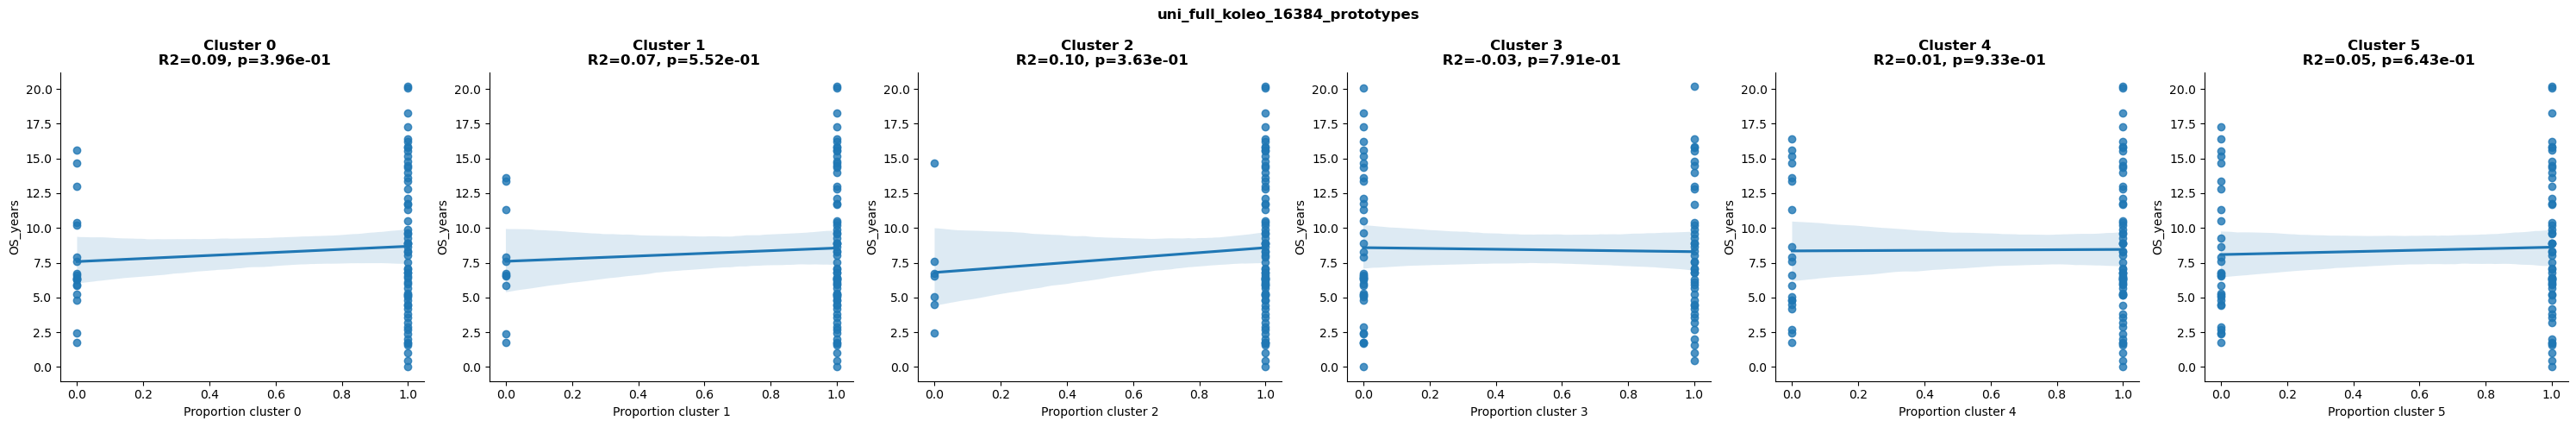

In [92]:
for name, n_cluster in zip(["uni", "uni_full_koleo_16384_prototypes"],
                [5,6]):
    filename = glob.glob(os.path.join(invasive_path,
                                        name, 
                                        f"invasive_labels_{optimal_clusters.loc[name, 'n_clusters']}_clusters_umap_min_dist*"))[0]
    df = pd.read_csv(filename, index_col=0)
    df["patient"] = [idx.split("_")[0] for idx in df.index]
    proportions = df.groupby(['patient', 'predicted_label']).size().unstack(fill_value=0)
    proportions = proportions.div(proportions.sum(axis=1), axis=0)
    proportions = (proportions > 0).astype(int)
    df_corr = proportions.merge(metadata[['OS_years', 'OS-event']], left_index=True, right_index=True)
    df_corr.dropna(inplace=True)

    plt.figure(figsize=(5*n_cluster,5))
    for cluster in range(n_cluster):

        plt.subplot(1,n_cluster,cluster+1)
        sns.regplot(x=df_corr[cluster],y=df_corr['OS_years'])
        r, p = pointbiserialr(df_corr[cluster], df_corr['OS_years'])
        plt.title(f"Cluster {cluster} \n R2={r:.2f}, p={p:.2e}", weight='bold')
        plt.xlabel(f"Proportion cluster {cluster}")
        sns.despine()
    plt.suptitle(name, weight='bold')
    plt.tight_layout()

## Classifiers

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler


# 1. Logistic regression from proportions to predict OS event

In [95]:
import numpy as np

summary_dict_cv = {}
n_splits = 25  # Number of cross-validation folds

for name, n_cluster in zip(["uni", "uni_full_koleo_16384_prototypes"],
                [5,6]):
    
    print(f"\n{'='*60}")
    print(f"Model: {name}")
    print(f"{'='*60}")
    
    summary_dict_cv[name] = {
        "accuracies": [],
        "balanced_accuracies": [],
        "roc_aucs": [],
        "fold_results": []
    }
    
    filename = glob.glob(os.path.join(invasive_path,
                                        name, 
                                        f"invasive_labels_{optimal_clusters.loc[name, 'n_clusters']}_clusters_umap_min_dist*"))[0]
    df = pd.read_csv(filename, index_col=0)
    df["patient"] = [idx.split("_")[0] for idx in df.index]
    proportions = df.groupby(['patient', 'predicted_label']).size().unstack(fill_value=0)
    proportions = proportions.div(proportions.sum(axis=1), axis=0)
    df_corr = proportions.merge(metadata[['OS_years', 'OS-event']], left_index=True, right_index=True)
    print(df_corr.head())
    
    # Remove rows with NaN values
    df_clean = df_corr[[i for i in range(n_cluster)] + ['OS-event']].dropna()
    X = df_clean[[i for i in range(n_cluster)]]
    Y = df_clean["OS-event"]
    
    print(f"Total samples: {len(Y)}")
    print(f"Class distribution: {Y.value_counts().to_dict()}\n")
    
    # Determine balanced test set size
    total_samples = len(Y)
    test_size_total = int(0.2 * total_samples)
    samples_per_class = test_size_total // 2
    
    # Separate by class
    minority_class = Y.value_counts().idxmin()
    majority_class = Y.value_counts().idxmax()
    
    X_minority = X[Y == minority_class].reset_index(drop=True)
    Y_minority = Y[Y == minority_class].reset_index(drop=True)
    X_majority = X[Y == majority_class].reset_index(drop=True)
    Y_majority = Y[Y == majority_class].reset_index(drop=True)
    
    # Perform cross-validation with balanced test sets
    for fold_idx in range(1, n_splits + 1):
        # Use different random states for each fold
        random_state = 42 + fold_idx
        
        # Split minority class
        X_minority_train, X_minority_test, Y_minority_train, Y_minority_test = train_test_split(
            X_minority, Y_minority, test_size=samples_per_class, random_state=random_state
        )
        
        # Split majority class
        X_majority_train, X_majority_test, Y_majority_train, Y_majority_test = train_test_split(
            X_majority, Y_majority, test_size=samples_per_class, random_state=random_state
        )
        
        # Combine for balanced test set
        X_test = pd.concat([X_minority_test, X_majority_test])
        Y_test = pd.concat([Y_minority_test, Y_majority_test])
        
        # Combine for training set
        X_train = pd.concat([X_minority_train, X_majority_train])
        Y_train = pd.concat([Y_minority_train, Y_majority_train])
        
        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train logistic regression
        log_reg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
        log_reg.fit(X_train_scaled, Y_train)
        
        # Predictions
        Y_pred = log_reg.predict(X_test_scaled)
        Y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]
        
        # Metrics
        acc = accuracy_score(Y_test, Y_pred)
        bal_acc = balanced_accuracy_score(Y_test, Y_pred)
        roc_auc = roc_auc_score(Y_test, Y_pred_proba)
        
        summary_dict_cv[name]["accuracies"].append(acc)
        summary_dict_cv[name]["balanced_accuracies"].append(bal_acc)
        summary_dict_cv[name]["roc_aucs"].append(roc_auc)
        
        summary_dict_cv[name]["fold_results"].append({
            "fold": fold_idx,
            "accuracy": acc,
            "balanced_accuracy": bal_acc,
            "roc_auc": roc_auc,
            "test_distribution": Y_test.value_counts().to_dict()
        })
    
    # Summary statistics
    print(f"\n{'-'*60}")
    print(f"Cross-Validation Summary for {name} (Balanced Test Sets):")
    print(f"{'-'*60}")
    print(f"Accuracy:          {np.mean(summary_dict_cv[name]['accuracies']):.3f} ± {np.std(summary_dict_cv[name]['accuracies']):.3f}")
    print(f"Balanced Accuracy: {np.mean(summary_dict_cv[name]['balanced_accuracies']):.3f} ± {np.std(summary_dict_cv[name]['balanced_accuracies']):.3f}")
    print(f"ROC-AUC:           {np.mean(summary_dict_cv[name]['roc_aucs']):.3f} ± {np.std(summary_dict_cv[name]['roc_aucs']):.3f}")
    
    summary_dict_cv[name]["mean_accuracy"] = np.mean(summary_dict_cv[name]["accuracies"])
    summary_dict_cv[name]["std_accuracy"] = np.std(summary_dict_cv[name]["accuracies"])
    summary_dict_cv[name]["mean_balanced_accuracy"] = np.mean(summary_dict_cv[name]["balanced_accuracies"])
    summary_dict_cv[name]["std_balanced_accuracy"] = np.std(summary_dict_cv[name]["balanced_accuracies"])
    summary_dict_cv[name]["mean_roc_auc"] = np.mean(summary_dict_cv[name]["roc_aucs"])
    summary_dict_cv[name]["std_roc_auc"] = np.std(summary_dict_cv[name]["roc_aucs"])


Model: uni
               0         1         2         3    4  OS_years  OS-event
TNBC1   0.221311  0.032787  0.598361  0.147541  0.0  8.284932       0.0
TNBC11  0.969754  0.003781  0.015123  0.011342  0.0  2.375342       1.0
TNBC12  0.020619  0.030928  0.195876  0.752577  0.0  5.156164       0.0
TNBC13  0.000000  0.000000  1.000000  0.000000  0.0  6.756164       0.0
TNBC14  0.000000  0.546841  0.031590  0.421569  0.0  6.816438       0.0
Total samples: 83
Class distribution: {0.0: 63, 1.0: 20}


------------------------------------------------------------
Cross-Validation Summary for uni (Balanced Test Sets):
------------------------------------------------------------
Accuracy:          0.650 ± 0.117
Balanced Accuracy: 0.650 ± 0.117
ROC-AUC:           0.727 ± 0.132

Model: uni_full_koleo_16384_prototypes
               0         1         2         3         4         5  OS_years  \
TNBC1   0.075472  0.264151  0.490566  0.000000  0.132075  0.037736  8.284932   
TNBC11  0.992634  0.0

In [103]:
import numpy as np

summary_dict_cv = {}
n_splits = 25  # Number of cross-validation folds

for name, n_cluster in zip(["uni", 
                            "uni_full_koleo_16384_prototypes"],
                           [5,6]):
    
    print(f"\n{'='*60}")
    print(f"Model: {name}")
    print(f"{'='*60}")
    
    summary_dict_cv[name] = {
        "accuracies": [],
        "balanced_accuracies": [],
        "roc_aucs": [],
        "fold_results": [],
        "f1-scores": [],
    }
    
    filename = glob.glob(os.path.join(invasive_path,
                                        name, 
                                        f"invasive_labels_{optimal_clusters.loc[name, 'n_clusters']}_clusters_umap_min_dist*"))[0]
    df = pd.read_csv(filename, index_col=0)
    df["patient"] = [idx.split("_")[0] for idx in df.index]
    proportions = df.groupby(['patient', 'predicted_label']).size().unstack(fill_value=0)
    proportions = proportions.div(proportions.sum(axis=1), axis=0)
    df_corr = proportions.merge(metadata[['OS_years', 'OS-event']], left_index=True, right_index=True)
    print(df_corr.head())
    
    # Remove rows with NaN values
    df_clean = df_corr[[i for i in range(n_cluster)] + ['OS-event']].dropna()
    X = df_clean[[i for i in range(n_cluster)]]
    Y = df_clean["OS-event"]
    
    print(f"Total samples: {len(Y)}")
    print(f"Class distribution: {Y.value_counts().to_dict()}\n")
    
    
    # Perform cross-validation with balanced test sets
    for fold_idx in range(1, n_splits + 1):
        # Use different random states for each fold
        random_state = 1 + fold_idx
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=0.2, random_state=random_state
        )

        
        # # Standardize features
        # scaler = StandardScaler()
        # X_train_scaled = scaler.fit_transform(X_train)
        # X_test_scaled = scaler.transform(X_test)
        
        # Train logistic regression
        log_reg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
        log_reg.fit(X_train, Y_train)
        
        # Predictions
        Y_pred = log_reg.predict(X_test)
        Y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
        
        # Metrics
        acc = accuracy_score(Y_test, Y_pred)
        bal_acc = balanced_accuracy_score(Y_test, Y_pred)
        roc_auc = roc_auc_score(Y_test, Y_pred_proba)
        
        summary_dict_cv[name]["accuracies"].append(acc)
        summary_dict_cv[name]["balanced_accuracies"].append(bal_acc)
        summary_dict_cv[name]["roc_aucs"].append(roc_auc)
        
        summary_dict_cv[name]["fold_results"].append({
            "fold": fold_idx,
            "accuracy": acc,
            "balanced_accuracy": bal_acc,
            "roc_auc": roc_auc,
            "test_distribution": Y_test.value_counts().to_dict()
        })
        
        from sklearn.metrics import f1_score
        f1 = f1_score(Y_test, Y_pred)
        summary_dict_cv[name]["f1-scores"].append(f1)
    
    # Summary statistics
    print(f"\n{'-'*60}")
    print(f"Cross-Validation Summary for {name}:")
    print(f"{'-'*60}")
    print(f"Accuracy:          {np.mean(summary_dict_cv[name]['accuracies']):.3f} ± {np.std(summary_dict_cv[name]['accuracies']):.3f}")
    print(f"Balanced Accuracy: {np.mean(summary_dict_cv[name]['balanced_accuracies']):.3f} ± {np.std(summary_dict_cv[name]['balanced_accuracies']):.3f}")
    print(f"ROC-AUC:           {np.mean(summary_dict_cv[name]['roc_aucs']):.3f} ± {np.std(summary_dict_cv[name]['roc_aucs']):.3f}")
    print(f"F1-score: {np.mean(summary_dict_cv[name]['f1-scores']):.3f} ± {np.std(summary_dict_cv[name]['f1-scores']):.3f}")
    
    summary_dict_cv[name]["mean_accuracy"] = np.mean(summary_dict_cv[name]["accuracies"])
    summary_dict_cv[name]["std_accuracy"] = np.std(summary_dict_cv[name]["accuracies"])
    summary_dict_cv[name]["mean_balanced_accuracy"] = np.mean(summary_dict_cv[name]["balanced_accuracies"])
    summary_dict_cv[name]["std_balanced_accuracy"] = np.std(summary_dict_cv[name]["balanced_accuracies"])
    summary_dict_cv[name]["mean_roc_auc"] = np.mean(summary_dict_cv[name]["roc_aucs"])
    summary_dict_cv[name]["std_roc_auc"] = np.std(summary_dict_cv[name]["roc_aucs"])
    summary_dict_cv[name]["f1-score"] = np.mean(summary_dict_cv[name]["f1-scores"])
    summary_dict_cv[name]["std_f1-score"] = np.std(summary_dict_cv[name]["f1-scores"])


Model: uni
               0         1         2         3    4  OS_years  OS-event
TNBC1   0.221311  0.032787  0.598361  0.147541  0.0  8.284932       0.0
TNBC11  0.969754  0.003781  0.015123  0.011342  0.0  2.375342       1.0
TNBC12  0.020619  0.030928  0.195876  0.752577  0.0  5.156164       0.0
TNBC13  0.000000  0.000000  1.000000  0.000000  0.0  6.756164       0.0
TNBC14  0.000000  0.546841  0.031590  0.421569  0.0  6.816438       0.0
Total samples: 83
Class distribution: {0.0: 63, 1.0: 20}

               0         1         2         3    4  OS_years  OS-event
TNBC1   0.221311  0.032787  0.598361  0.147541  0.0  8.284932       0.0
TNBC11  0.969754  0.003781  0.015123  0.011342  0.0  2.375342       1.0
TNBC12  0.020619  0.030928  0.195876  0.752577  0.0  5.156164       0.0
TNBC13  0.000000  0.000000  1.000000  0.000000  0.0  6.756164       0.0
TNBC14  0.000000  0.546841  0.031590  0.421569  0.0  6.816438       0.0
Total samples: 83
Class distribution: {0.0: 63, 1.0: 20}


-------

# 2. Linear regression from proportions to predict OS years

In [104]:
# Linear Regression for OS_years prediction
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

summary_dict_cv_linear = {}
n_splits = 25  # Number of cross-validation folds

for name, n_cluster in zip(["uni", "uni_full_koleo_16384_prototypes"],
                [5,6]):
    print(f"\n{'='*60}")
    print(f"Model: {name}")
    print(f"{'='*60}")
    
    summary_dict_cv_linear[name] = {
        "mse": [],
        "rmse": [],
        "mae": [],
        "r2": [],
        "fold_results": []
    }
    
    filename = glob.glob(os.path.join(invasive_path,
                                        name, 
                                        f"invasive_labels_{optimal_clusters.loc[name, 'n_clusters']}_clusters_umap_min_dist*"))[0]
    df = pd.read_csv(filename, index_col=0)
    df["patient"] = [idx.split("_")[0] for idx in df.index]
    proportions = df.groupby(['patient', 'predicted_label']).size().unstack(fill_value=0)
    proportions = proportions.div(proportions.sum(axis=1), axis=0)
    df_corr = proportions.merge(metadata[['OS_years', 'OS-event']], left_index=True, right_index=True)
    
    # Remove rows with NaN values
    df_clean = df_corr[[i for i in range(n_cluster)] + ['OS_years']].dropna()
    X = df_clean[[i for i in range(n_cluster)]]
    Y = df_clean["OS_years"]
    
    print(f"Total samples: {len(Y)}")
    print(f"OS_years range: [{Y.min():.2f}, {Y.max():.2f}], mean: {Y.mean():.2f}\n")
    
    # Determine test set size (20% of total data)
    total_samples = len(Y)
    test_size = int(0.2 * total_samples)
    
    # Perform cross-validation
    for fold_idx in range(1, n_splits + 1):
        # Use different random states for each fold
        random_state = 42 + fold_idx
        
        # Split data
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=test_size, random_state=random_state
        )
        
        # Standardize features
        # scaler = StandardScaler()
        # X_train_scaled = scaler.fit_transform(X_train)
        # X_test_scaled = scaler.transform(X_test)
        
        # Train linear regression
        lin_reg = LinearRegression()
        lin_reg.fit(X_train, Y_train)
        
        # Predictions
        Y_pred = lin_reg.predict(X_test)
        
        # Metrics
        mse = mean_squared_error(Y_test, Y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(Y_test, Y_pred)
        r2 = r2_score(Y_test, Y_pred)
        
        summary_dict_cv_linear[name]["mse"].append(mse)
        summary_dict_cv_linear[name]["rmse"].append(rmse)
        summary_dict_cv_linear[name]["mae"].append(mae)
        summary_dict_cv_linear[name]["r2"].append(r2)
        
        summary_dict_cv_linear[name]["fold_results"].append({
            "fold": fold_idx,
            "mse": mse,
            "rmse": rmse,
            "mae": mae,
            "r2": r2
        })
    
    # Summary statistics
    print(f"\n{'-'*60}")
    print(f"Cross-Validation Summary for {name} (Linear Regression):")
    print(f"{'-'*60}")
    print(f"RMSE:  {np.mean(summary_dict_cv_linear[name]['rmse']):.3f} ± {np.std(summary_dict_cv_linear[name]['rmse']):.3f}")
    print(f"MAE:   {np.mean(summary_dict_cv_linear[name]['mae']):.3f} ± {np.std(summary_dict_cv_linear[name]['mae']):.3f}")
    print(f"R²:    {np.mean(summary_dict_cv_linear[name]['r2']):.3f} ± {np.std(summary_dict_cv_linear[name]['r2']):.3f}")
    
    summary_dict_cv_linear[name]["mean_rmse"] = np.mean(summary_dict_cv_linear[name]["rmse"])
    summary_dict_cv_linear[name]["std_rmse"] = np.std(summary_dict_cv_linear[name]["rmse"])
    summary_dict_cv_linear[name]["mean_mae"] = np.mean(summary_dict_cv_linear[name]["mae"])
    summary_dict_cv_linear[name]["std_mae"] = np.std(summary_dict_cv_linear[name]["mae"])
    summary_dict_cv_linear[name]["mean_r2"] = np.mean(summary_dict_cv_linear[name]["r2"])
    summary_dict_cv_linear[name]["std_r2"] = np.std(summary_dict_cv_linear[name]["r2"])


Model: uni
Total samples: 83
OS_years range: [0.00, 20.19], mean: 8.43

Total samples: 83
OS_years range: [0.00, 20.19], mean: 8.43


------------------------------------------------------------
Cross-Validation Summary for uni (Linear Regression):
------------------------------------------------------------
RMSE:  13.362 ± 22.290
MAE:   6.401 ± 5.873
R²:    -26.027 ± 73.822

Model: uni_full_koleo_16384_prototypes
Total samples: 83
OS_years range: [0.00, 20.19], mean: 8.43


------------------------------------------------------------
Cross-Validation Summary for uni (Linear Regression):
------------------------------------------------------------
RMSE:  13.362 ± 22.290
MAE:   6.401 ± 5.873
R²:    -26.027 ± 73.822

Model: uni_full_koleo_16384_prototypes
Total samples: 83
OS_years range: [0.00, 20.19], mean: 8.43


------------------------------------------------------------
Cross-Validation Summary for uni_full_koleo_16384_prototypes (Linear Regression):
------------------------------